## 1 of 2: Drugs of abuse in biological samples: Quality Control Data Analysis

This is notebook 1 of 2 and is designed to import two data exports from Masshunter which contains data for the analysis of drugs in blood samples - one contains quality control data and the other contains casework sample data. The QC data is assessed for accuracy against acceptable limits and casework samples are processed for the presence of any drug compounds of interest. Any quality failures (qualifier ratios, low ISTD response or replicate disagreement) are analysed and presented where needed.
(for future revisions - only require 1 Masshunter export)

In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Load the Quality Control results

In [14]:
df_stds = pd.read_csv('standards_export4.csv')
df_stds.drop(index = 0, inplace=True)
df_stds.rename(columns = lambda x: x.replace(' Results', ''), inplace=True)
df_stds.rename(columns={'Benzoylecgonine': 'BZE', 'Cocaethylene': 'CE'}, inplace=True)
df_stds.set_index('Sample', inplace=True)

In [3]:
compounds = df_stds.columns

for i in compounds:
    df_stds[i] = np.float64(df_stds[i]).round(2)
    
df_cals = df_stds[df_stds.index.str.startswith('BCAL')]
df_qcs = df_stds[df_stds.index.str.startswith('BQC')]
sample_names = df_qcs.index

Add columns for quality control acceptance / failure

In [4]:
new_cols = ['Coc_ok', 'BZE_ok', 'MDMA_ok', 'MDA_ok', 'CE_ok']

In [5]:
i = 1
for column in new_cols:
    df_qcs.insert(i, column, ' ')
    i += 2

In [6]:
def check_qc1_accuracy(sample, x):
    
    # feed in the sample name and the concentration
    # determine its target concentration and limits
    # calculate if conc falls within acceptable range
    
    
    if sample.find('1')>0:
        target = 6
    if sample.find('2')>0:
        target = 36
    if sample.find('3')>0:
        target = 72

    low_limit = target * .8
    high_limit = target * 1.2
    
    if x > low_limit and x < high_limit: return True
    else: return False

Fill in pass / fail for each Quality Contorl sample for all drugs

In [7]:
i = 0
for sample in sample_names:
    for compound in compounds:
        if check_qc1_accuracy(sample, df_qcs.at[sample, compound]):
            df_qcs.at[sample, new_cols[i]] = 'ok'

        elif not check_qc1_accuracy(sample, df_qcs.at[sample, compound]):
            df_qcs.at[sample, new_cols[i]] = 'x'   
        i += 1
    i = 0

Formatting

In [8]:
def highlight_cells(x):
    color = None
    if x == 'x': 
        color = 'red'
    if x == 'ok':
        color = 'green'
    return 'color: %s' % color

# Quality Control Sample Success:

In [9]:
df_qcs.style.applymap(highlight_cells, subset=new_cols)

,Cocaine,Coc_ok,BZE,BZE_ok,MDMA,MDMA_ok,MDA,MDA_ok,CE,CE_ok
Sample,,,,,,,,,,
BQC_1A_Start,6.15,ok,7,ok,6.39,ok,5.64,ok,5.92,ok
BQC_1B_Start,6.23,ok,7.19,ok,5.23,ok,5.16,ok,6.84,ok
BQC_2A_Start,36.85,ok,44.59,x,38.53,ok,39.76,ok,37.13,ok
BQC_2B_Start,35.63,ok,37.99,ok,37.88,ok,40.2,ok,38.1,ok
BQC_3A_Start,79.65,ok,69.82,ok,69.26,ok,83.31,ok,60.27,ok
BQC_3B_Start,69.83,ok,69.59,ok,61.92,ok,79.95,ok,73.26,ok
BQC_1A_End,7.34,x,6.85,ok,5.16,ok,3.87,x,6.6,ok
BQC_1B_End,6.28,ok,6.79,ok,5.94,ok,3.55,x,6.68,ok
BQC_2A_End,35.41,ok,36.32,ok,37,ok,31.29,ok,34.53,ok


# Regression Analysis

In [10]:
df_cals

,Cocaine,BZE,MDMA,MDA,CE
Sample,,,,,
BCAL_1,1.26,2.48,0.94,0.68,1.79
BCAL_2,4.32,4.78,4.52,4.80,4.98
BCAL_3,9.48,11.13,10.82,10.77,10.29
BCAL_4,17.43,17.91,19.28,18.13,19.14
BCAL_5,39.49,41.33,43.20,43.23,40.93
BCAL_6,64.72,61.24,61.20,70.15,59.66
BCAL_7,79.30,78.62,75.97,78.07,64.97


In [11]:
cal_concs = [1, 5, 10, 20, 40, 65, 80]
qc_concs = [6, 6, 36, 36, 72, 72, 6, 6, 36, 36, 72, 72]

Text(10,60,'y = 1.0218x + 0.0')

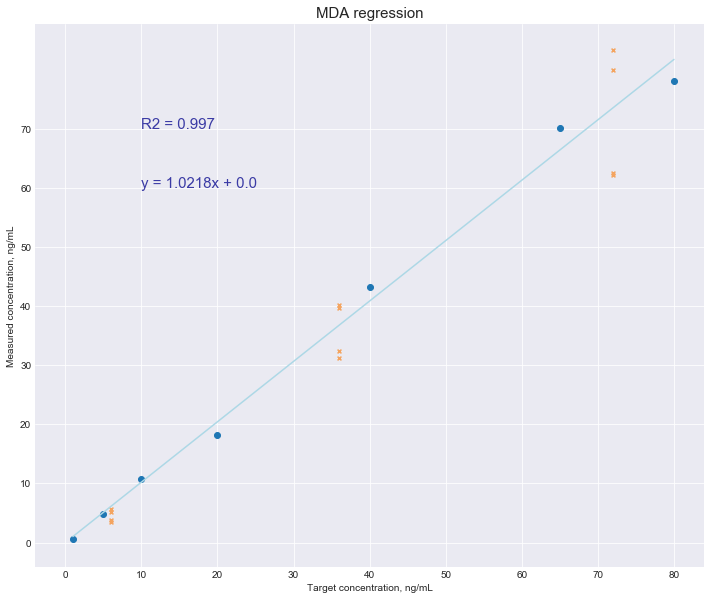

In [12]:
compound = 'MDA'
size = 10

sns.set_style('darkgrid')
plt.figure(figsize=(size*1.2,size))
plt.scatter(cal_concs, df_cals[compound])
plt.scatter(qc_concs, df_qcs[compound], marker='x', c='#F4A460', s = 15)
plt.xlabel('Target concentration, ng/mL')
plt.ylabel('Measured concentration, ng/mL')
plt.title('{} regression'.format(compound), size=15)
plt.yticks(np.arange(0, 80, step=10), ('0', '10', '20', '30', '40', '50', '60', '70', '80'))

r2 = 'R2 = {}'.format(round(np.corrcoef(cal_concs, df_cals[compound])[0][1],3))
plt.annotate(r2, (10,70), size=15, color='darkblue', alpha = 0.75)


# plot best-fit line
X = np.array(cal_concs)
Y = np.array(list(df_cals[compound]))
slope, intercept = np.polyfit(X, Y, 1)
plt.plot(X, X*slope + intercept, 'lightblue', '--')

equation = 'y = {}x + {}'.format(round(slope,4), round(intercept))
plt.annotate(equation, (10, 60), size=15, color='darkblue', alpha = 0.75)